In [1]:
# Comprehensive Data Preprocessing on Movies Dataset

# Import necessary libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from collections import Counter

In [2]:
# Load credits.csv
credits = pd.read_csv('./raw-data/credits.csv')

# Load keywords.csv
keywords = pd.read_csv('./raw-data/keywords.csv')

# Load links.csv
links = pd.read_csv('./raw-data/links.csv')

# Load movies_metadata.csv
movies_metadata = pd.read_csv('./raw-data/movies_metadata.csv', low_memory=False)

# Load ratings.csv
ratings = pd.read_csv('./raw-data/ratings.csv')

In [3]:
# Function to safely parse JSON-like strings
def parse_json_column(df, column_name):
    def parse_json(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except:
            return []
    df[column_name] = df[column_name].apply(parse_json)
    return df

In [4]:
# Parse columns in credits dataframe
credits = parse_json_column(credits, 'cast')
credits = parse_json_column(credits, 'crew')

# Parse keywords dataframe
keywords = parse_json_column(keywords, 'keywords')

# Parse columns in movies_metadata dataframe
json_columns = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'belongs_to_collection']
for column in json_columns:
    movies_metadata = parse_json_column(movies_metadata, column)

In [5]:
# Convert numeric columns to appropriate data types
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce')
movies_metadata['revenue'] = pd.to_numeric(movies_metadata['revenue'], errors='coerce')
movies_metadata['runtime'] = pd.to_numeric(movies_metadata['runtime'], errors='coerce')
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
credits['id'] = pd.to_numeric(credits['id'], errors='coerce')
keywords['id'] = pd.to_numeric(keywords['id'], errors='coerce')
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')

In [6]:
# Replace zero budgets or revenues with NaN
movies_metadata['budget'] = movies_metadata['budget'].replace(0, np.nan)
movies_metadata['revenue'] = movies_metadata['revenue'].replace(0, np.nan)

# Check missing values
movies_metadata[['budget', 'revenue', 'runtime']].isnull().sum()

budget     36576
revenue    38058
runtime      263
dtype: int64

In [7]:
# Impute missing numerical values with median
imputer = SimpleImputer(strategy='median')
movies_metadata[['budget', 'revenue', 'runtime']] = imputer.fit_transform(movies_metadata[['budget', 'revenue', 'runtime']])

In [8]:
# Merge credits and movies_metadata on 'id'
df = movies_metadata.merge(credits, on='id', how='left')

# Merge keywords
df = df.merge(keywords, on='id', how='left')

In [9]:
# List of numerical features
numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count']

# List of categorical features
categorical_features = ['original_language', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'crew', 'keywords', 'belongs_to_collection']

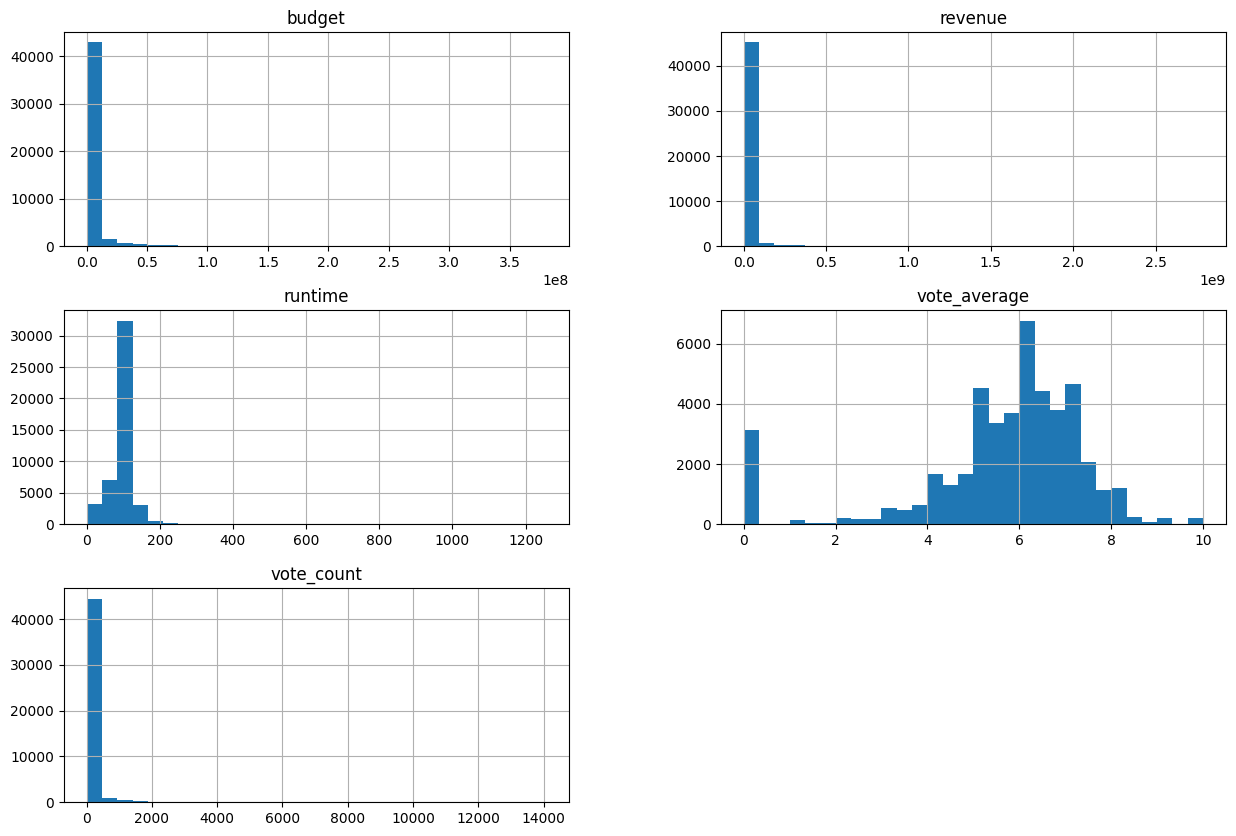

In [10]:
# Plot histograms
df[numerical_features].hist(bins=30, figsize=(15,10))
plt.show()

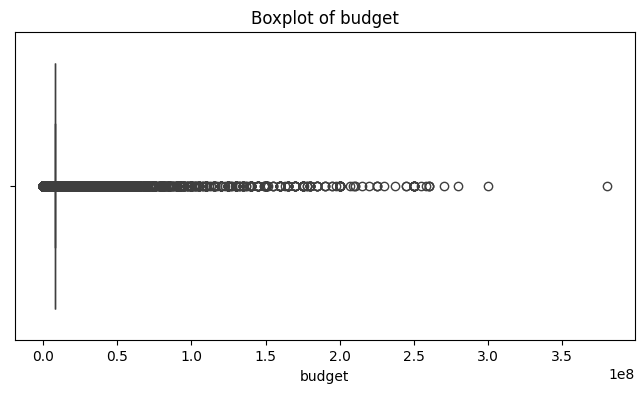

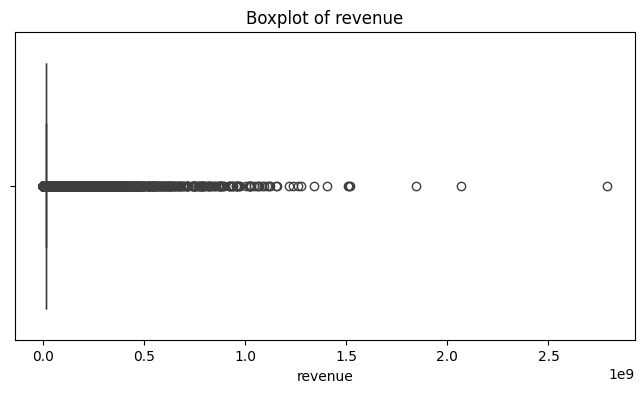

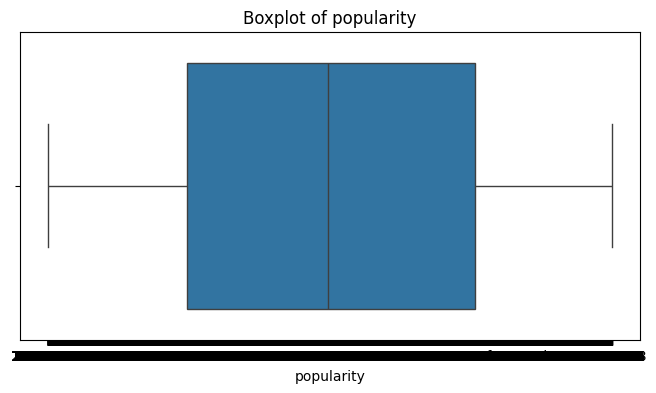

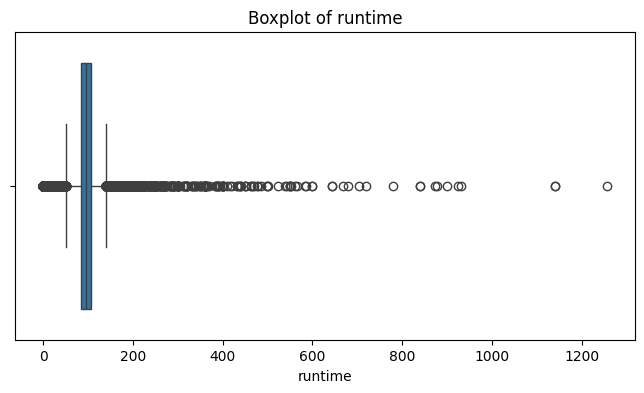

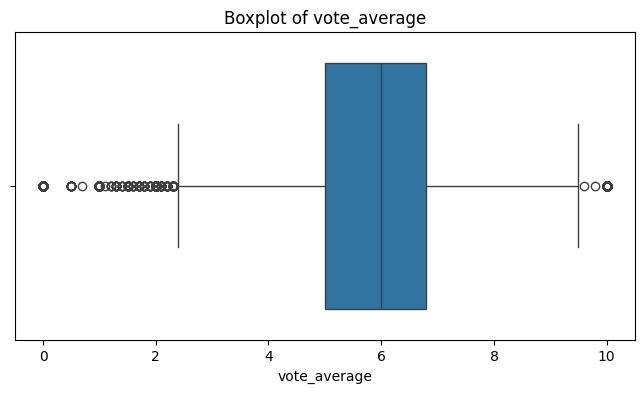

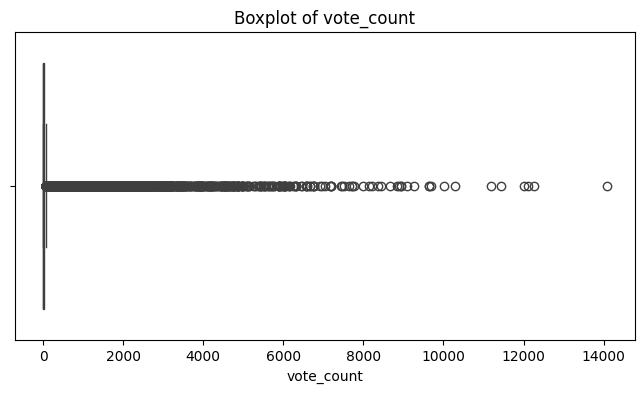

In [11]:
# Boxplots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

In [12]:
scaler = RobustScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

ValueError: could not convert string to float: 'Beware Of Frost Bites'

In [13]:
def get_names(x, key='name'):
    if isinstance(x, list):
        return [i.get(key) for i in x if i.get(key)]
    return []

In [14]:
# Extract genre names
df['genres_list'] = df['genres'].apply(get_names)

# Count frequency of genres
genre_counter = Counter([genre for genres in df['genres_list'] for genre in genres])

# Remove sparse genres (appearing in less than 50 movies)
sparse_genres = [genre for genre, count in genre_counter.items() if count < 50]
df['genres_list'] = df['genres_list'].apply(lambda x: [genre for genre in x if genre not in sparse_genres])

# One-Hot Encode genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(df['genres_list'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb_genres.classes_, index=df.index)

NameError: name 'MultiLabelBinarizer' is not defined

In [ ]:
# Count frequency of languages
language_counts = df['original_language'].value_counts()

# Keep languages that appear more than 100 times
rich_languages = language_counts[language_counts > 100].index.tolist()

# Replace sparse languages with 'Other'
df['original_language'] = df['original_language'].apply(lambda x: x if x in rich_languages else 'Other')

# Label encode original language
le_language = LabelEncoder()
df['original_language_encoded'] = le_language.fit_transform(df['original_language'])

In [ ]:
# Extract production company names
df['production_companies_list'] = df['production_companies'].apply(get_names)

# Count frequency of production companies
company_counter = Counter([company for companies in df['production_companies_list'] for company in companies])

# Keep top 20 production companies
top_companies = [company for company, count in company_counter.most_common(20)]
df['production_companies_list'] = df['production_companies_list'].apply(lambda x: [company for company in x if company in top_companies])

# One-Hot Encode production companies
mlb_companies = MultiLabelBinarizer()
companies_encoded = mlb_companies.fit_transform(df['production_companies_list'])
companies_df = pd.DataFrame(companies_encoded, columns=mlb_companies.classes_, index=df.index)

In [ ]:
# Extract cast names (top 3)
def get_top_cast(x, n=3):
    if isinstance(x, list):
        return [i.get('name') for i in x[:n] if i.get('name')]
    return []

df['cast_list'] = df['cast'].apply(get_top_cast)

# Count frequency of cast members
cast_counter = Counter([cast for casts in df['cast_list'] for cast in casts])

# Keep top 50 cast members
top_cast = [cast for cast, count in cast_counter.most_common(50)]
df['cast_list'] = df['cast_list'].apply(lambda x: [cast for cast in x if cast in top_cast])

# One-Hot Encode cast members
mlb_cast = MultiLabelBinarizer()
cast_encoded = mlb_cast.fit_transform(df['cast_list'])
cast_df = pd.DataFrame(cast_encoded, columns=mlb_cast.classes_, index=df.index)

In [ ]:
# Extract director name
def get_director(x):
    if isinstance(x, list):
        for i in x:
            if i.get('job') == 'Director':
                return i.get('name')
    return np.nan

df['director'] = df['crew'].apply(get_director)

# Count frequency of directors
director_counts = df['director'].value_counts()

# Keep directors who have directed more than 5 movies
rich_directors = director_counts[director_counts > 5].index.tolist()
df['director'] = df['director'].apply(lambda x: x if x in rich_directors else 'Other')

# Label encode directors
le_director = LabelEncoder()
df['director_encoded'] = le_director.fit_transform(df['director'].fillna('Unknown'))

In [ ]:
# Extract keywords
df['keywords_list'] = df['keywords'].apply(get_names)

# Count frequency of keywords
keyword_counter = Counter([keyword for keywords in df['keywords_list'] for keyword in keywords])

# Keep top 100 keywords
top_keywords = [keyword for keyword, count in keyword_counter.most_common(100)]
df['keywords_list'] = df['keywords_list'].apply(lambda x: [keyword for keyword in x if keyword in top_keywords])

# One-Hot Encode keywords
mlb_keywords = MultiLabelBinarizer()
keywords_encoded = mlb_keywords.fit_transform(df['keywords_list'])
keywords_df = pd.DataFrame(keywords_encoded, columns=mlb_keywords.classes_, index=df.index)

In [ ]:
# Concatenate all one-hot encoded dataframes
df_encoded = pd.concat([df[numerical_features],
                        genres_df,
                        companies_df,
                        cast_df,
                        df[['original_language_encoded', 'director_encoded']],
                        keywords_df], axis=1)

# Replace NaN with zeros (if any)
df_encoded = df_encoded.fillna(0)

In [ ]:
# Check if any missing values remain
missing_values = df_encoded.isnull().sum().sum()
print(f'Total missing values in the dataset: {missing_values}')

In [ ]:
# Remove features with low variance (sparse features)
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
df_encoded_reduced = selector.fit_transform(df_encoded)

# Get the names of the remaining features
features_selected = df_encoded.columns[selector.get_support(indices=True)]
df_encoded = pd.DataFrame(df_encoded_reduced, columns=features_selected)

In [ ]:
# Define target variable
df['revenue_budget_ratio'] = df['revenue'] / df['budget']

# Replace infinite values with NaN and drop them
df['revenue_budget_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['revenue_budget_ratio'], inplace=True)

# Add target variable to encoded dataframe
df_encoded['revenue_budget_ratio'] = df['revenue_budget_ratio']

# Final feature matrix and target variable
X = df_encoded.drop('revenue_budget_ratio', axis=1)
y = df_encoded['revenue_budget_ratio']